In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)

Libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6


In [2]:
# Dataset paths
DATASET_PATH = "/Users/rishad/Downloads/Lab/Dataset"
CAT_PATH = os.path.join(DATASET_PATH, "Cat")
DOG_PATH = os.path.join(DATASET_PATH, "Dog")

def explore_dataset():
    """Explore the dataset structure and display basic statistics"""
    cat_images = [f for f in os.listdir(CAT_PATH) if f.endswith('.jpg')]
    dog_images = [f for f in os.listdir(DOG_PATH) if f.endswith('.jpg')]
    
    print("Dataset Exploration:")
    print("=" * 50)
    print(f"Cat images: {len(cat_images)}")
    print(f"Dog images: {len(dog_images)}")
    print(f"Total images: {len(cat_images) + len(dog_images)}")
    print(f"Class distribution: {len(cat_images)/(len(cat_images) + len(dog_images)):.2%} cats, {len(dog_images)/(len(cat_images) + len(dog_images)):.2%} dogs")
    
    return cat_images, dog_images

# Explore the dataset
cat_images, dog_images = explore_dataset()

Dataset Exploration:
Cat images: 50
Dog images: 50
Total images: 100
Class distribution: 50.00% cats, 50.00% dogs


In [3]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    """Load and preprocess an image"""
    try:
        # Load image using OpenCV
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Normalize pixel values to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def extract_features(img):
    """Extract features from an image for Bayesian classification"""
    if img is None:
        return None
    
    features = []
    
    # 1. Color histogram features
    # RGB histograms
    for i in range(3):  # R, G, B channels
        hist = cv2.calcHist([img], [i], None, [8], [0, 1])  # 8 bins per channel
        features.extend(hist.flatten())
    
    # 2. Statistical features (mean, std, skewness, kurtosis for each channel)
    for i in range(3):
        channel = img[:, :, i]
        features.extend([
            np.mean(channel),
            np.std(channel),
            # Skewness approximation
            np.mean((channel - np.mean(channel))**3) / (np.std(channel)**3 + 1e-7),
            # Kurtosis approximation
            np.mean((channel - np.mean(channel))**4) / (np.std(channel)**4 + 1e-7)
        ])
    
    # 3. Texture features using Local Binary Pattern approximation
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Simple texture measure: standard deviation of Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    texture_score = np.var(laplacian)
    features.append(texture_score)
    
    # 4. Edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    features.append(edge_density)
    
    # 5. Brightness and contrast
    brightness = np.mean(gray)
    contrast = np.std(gray)
    features.extend([brightness, contrast])
    
    return np.array(features)

print("Feature extraction functions defined successfully!")
print("Feature vector will have dimensions:", 8*3 + 4*3 + 1 + 1 + 2, "features")

Feature extraction functions defined successfully!
Feature vector will have dimensions: 40 features


In [4]:
def load_dataset():
    """Load and preprocess the entire dataset"""
    print("Loading dataset...")
    
    X = []  # Features
    y = []  # Labels
    
    # Load cat images (label = 0)
    print("Loading cat images...")
    for i, img_name in enumerate(cat_images):
        if i % 10 == 0:
            print(f"Processing cat image {i+1}/{len(cat_images)}")
        
        img_path = os.path.join(CAT_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        
        if img is not None:
            features = extract_features(img)
            if features is not None:
                X.append(features)
                y.append(0)  # Cat = 0
    
    # Load dog images (label = 1)
    print("Loading dog images...")
    for i, img_name in enumerate(dog_images):
        if i % 10 == 0:
            print(f"Processing dog image {i+1}/{len(dog_images)}")
        
        img_path = os.path.join(DOG_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        
        if img is not None:
            features = extract_features(img)
            if features is not None:
                X.append(features)
                y.append(1)  # Dog = 1
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nDataset loaded successfully!")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of cat samples: {np.sum(y == 0)}")
    print(f"Number of dog samples: {np.sum(y == 1)}")
    
    return X, y

# Load the dataset
X, y = load_dataset()

Loading dataset...
Loading cat images...
Processing cat image 1/50
Processing cat image 11/50
Processing cat image 21/50
Processing cat image 31/50
Processing cat image 41/50
Loading dog images...
Processing dog image 1/50
Processing dog image 11/50
Processing dog image 21/50
Processing dog image 31/50
Processing dog image 41/50

Dataset loaded successfully!
Feature matrix shape: (100, 40)
Labels shape: (100,)
Number of cat samples: 50
Number of dog samples: 50


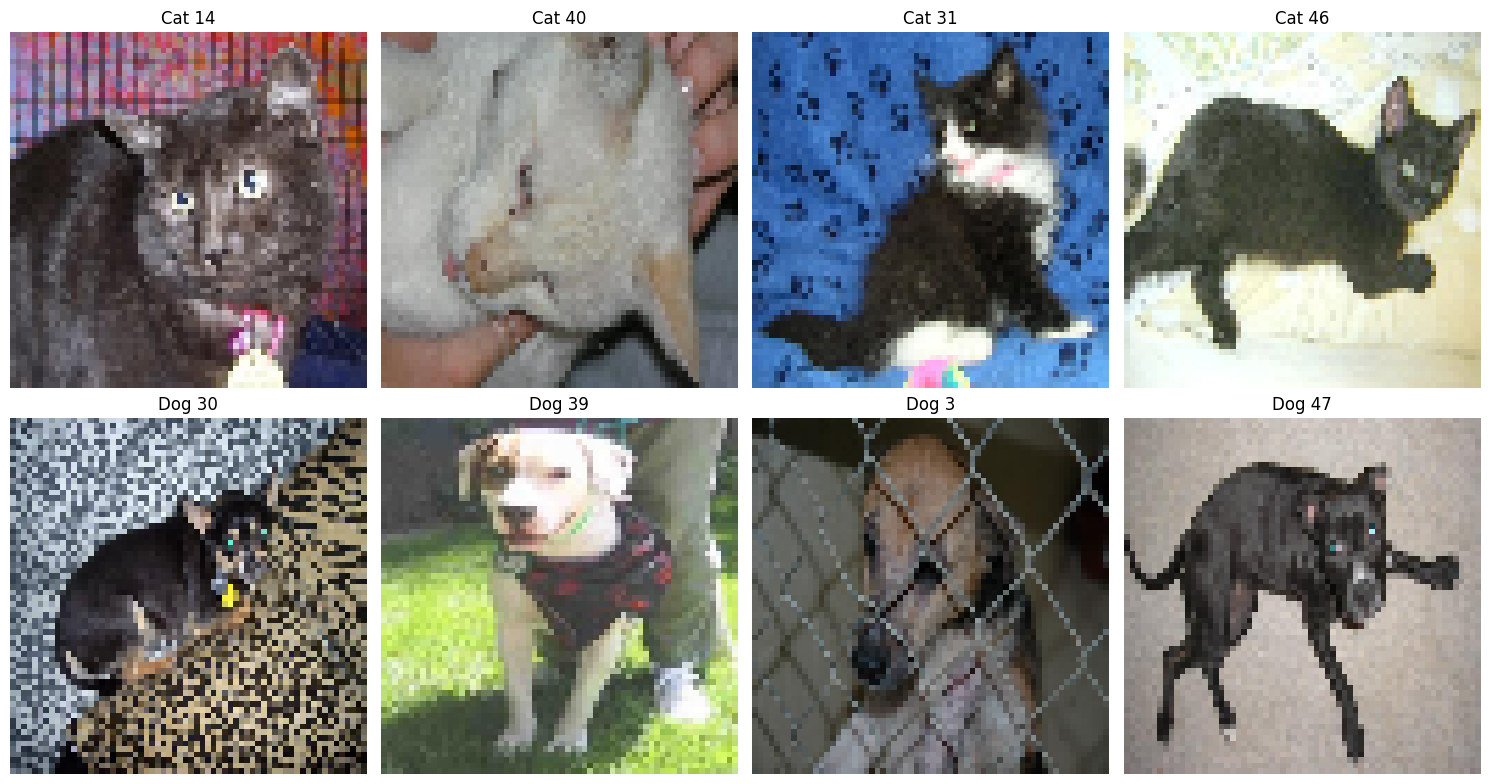

In [5]:
# Visualize some sample images and their features
def visualize_samples():
    """Visualize sample images from both classes"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    
    # Show some cat images
    cat_samples = np.random.choice([i for i in range(len(y)) if y[i] == 0], 4, replace=False)
    for i, idx in enumerate(cat_samples):
        # Reconstruct image path
        cat_img_path = os.path.join(CAT_PATH, cat_images[idx])
        img = load_and_preprocess_image(cat_img_path)
        if img is not None:
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Cat {idx+1}')
            axes[0, i].axis('off')
    
    # Show some dog images
    dog_samples = np.random.choice([i for i in range(len(y)) if y[i] == 1], 4, replace=False)
    for i, idx in enumerate(dog_samples):
        # Find the actual dog index
        dog_idx = idx - 50  # Adjust for the fact that dogs start after cats
        dog_img_path = os.path.join(DOG_PATH, dog_images[dog_idx])
        img = load_and_preprocess_image(dog_img_path)
        if img is not None:
            axes[1, i].imshow(img)
            axes[1, i].set_title(f'Dog {dog_idx+1}')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples()

Total features: 40


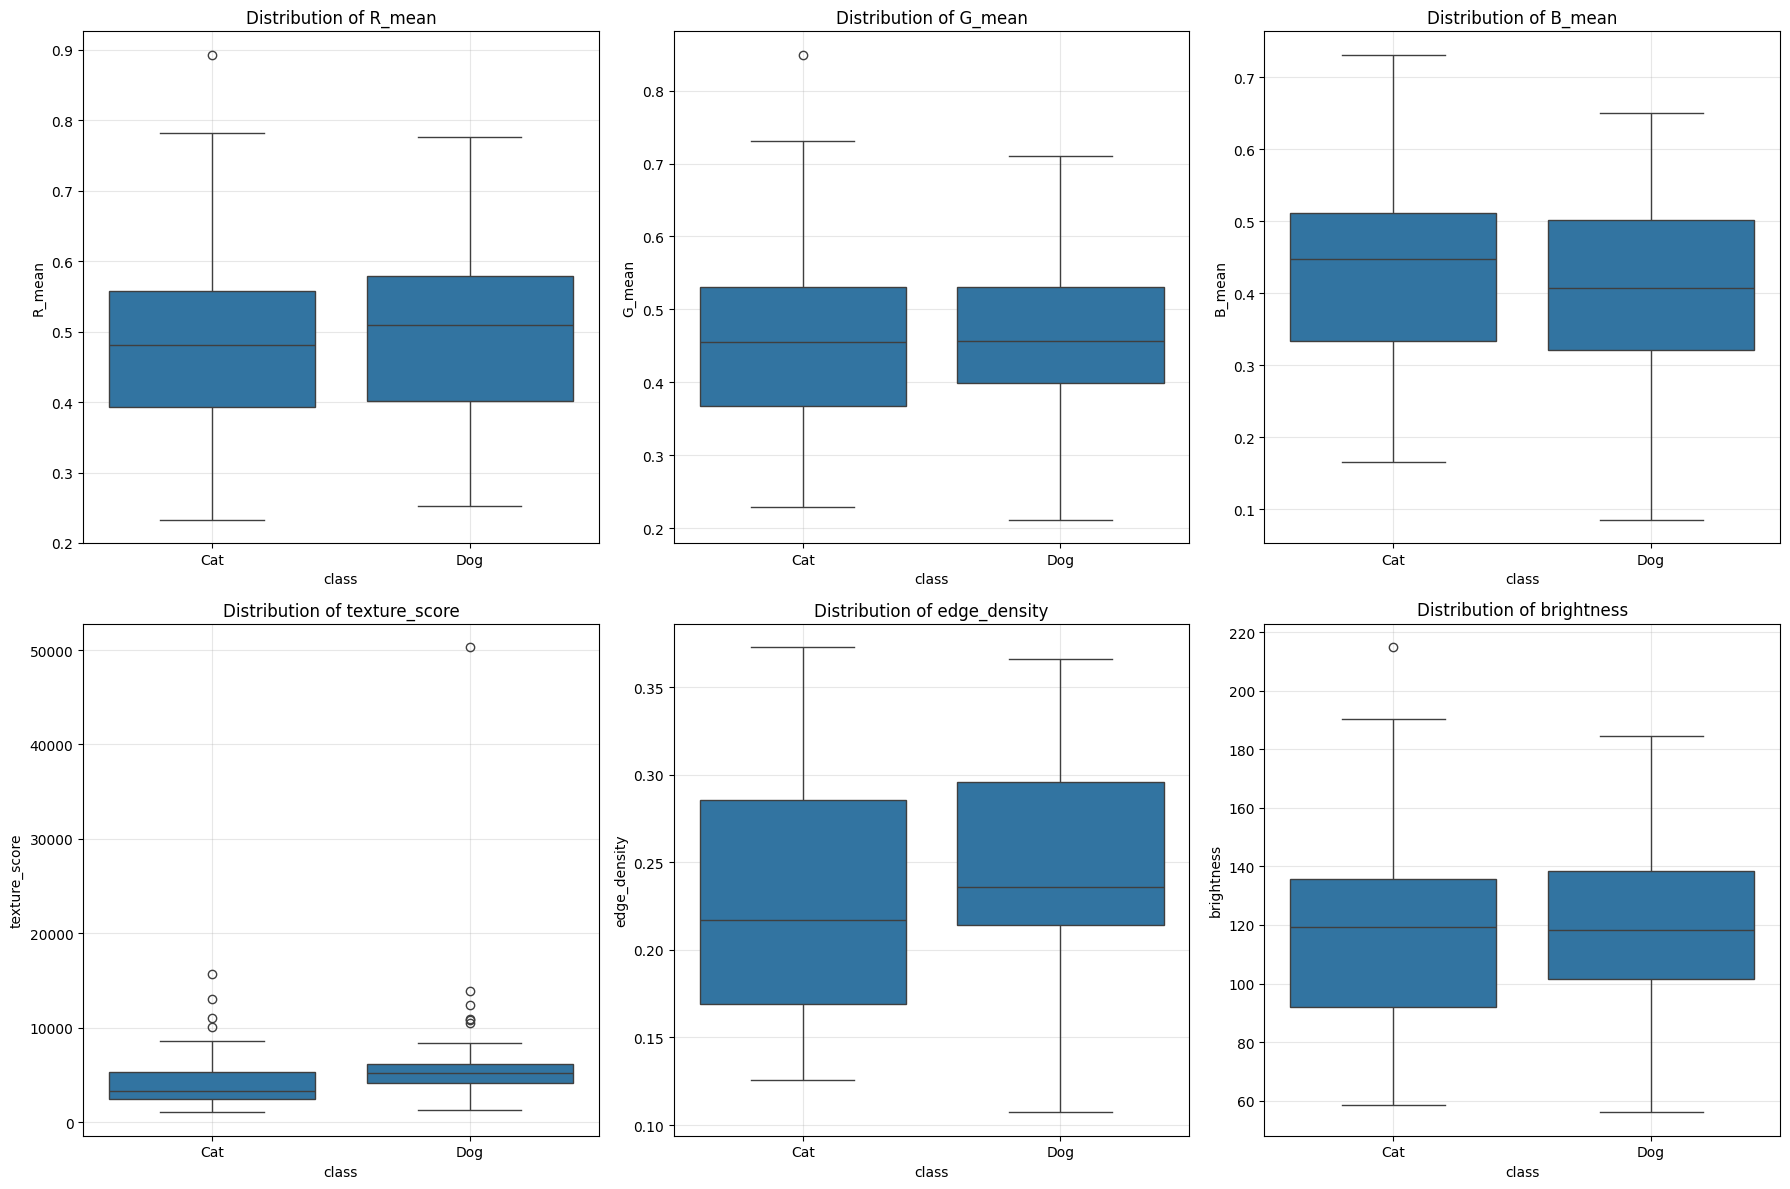


Feature Statistics by Class:
       R_mean          G_mean          B_mean         texture_score  \
         mean     std    mean     std    mean     std          mean   
class                                                                 
Cat    0.4795  0.1305  0.4521  0.1253  0.4290  0.1267     4379.4161   
Dog    0.4918  0.1141  0.4571  0.1003  0.4106  0.1206     6513.2108   

                 edge_density         brightness           
             std         mean     std       mean      std  
class                                                      
Cat    3089.1052       0.2316  0.0671   116.7090  31.2718  
Dog    6812.9875       0.2473  0.0589   117.8603  25.9342  


In [6]:
# Analyze feature distributions
def analyze_features():
    """Analyze and visualize feature distributions"""
    
    # Create feature names
    feature_names = []
    
    # Color histogram features (8 bins x 3 channels = 24 features)
    for channel in ['R', 'G', 'B']:
        for bin_idx in range(8):
            feature_names.append(f'{channel}_hist_bin_{bin_idx}')
    
    # Statistical features (4 stats x 3 channels = 12 features)
    for channel in ['R', 'G', 'B']:
        feature_names.extend([f'{channel}_mean', f'{channel}_std', f'{channel}_skew', f'{channel}_kurt'])
    
    # Texture and other features (4 features)
    feature_names.extend(['texture_score', 'edge_density', 'brightness', 'contrast'])
    
    print(f"Total features: {len(feature_names)}")
    
    # Create DataFrame for easier analysis
    df = pd.DataFrame(X, columns=feature_names)
    df['class'] = ['Cat' if label == 0 else 'Dog' for label in y]
    
    # Plot distributions of key features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    key_features = ['R_mean', 'G_mean', 'B_mean', 'texture_score', 'edge_density', 'brightness']
    
    for i, feature in enumerate(key_features):
        sns.boxplot(data=df, x='class', y=feature, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\nFeature Statistics by Class:")
    print("=" * 50)
    summary = df.groupby('class')[key_features].agg(['mean', 'std']).round(4)
    print(summary)
    
    return df

df = analyze_features()

In [7]:
# Split the data and implement Bayesian classification
def implement_bayesian_classification():
    """Implement and evaluate different Bayesian classifiers"""
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    print("Data split:")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    # Feature scaling (important for Gaussian Naive Bayes)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize Bayesian classifiers
    classifiers = {
        'Gaussian Naive Bayes': GaussianNB(),
        'Gaussian NB (scaled)': GaussianNB(),
        'Multinomial NB': MultinomialNB(alpha=1.0)
    }
    
    results = {}
    
    print("\n" + "="*60)
    print("BAYESIAN CLASSIFICATION RESULTS")
    print("="*60)
    
    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"\n{name}:")
        print("-" * 40)
        
        if name == 'Gaussian NB (scaled)':
            # Use scaled features
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)
            
            # Cross-validation with scaled data
            cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
        elif name == 'Multinomial NB':
            # Multinomial NB requires non-negative features
            # Shift features to make them positive
            X_train_pos = X_train - X_train.min() + 1e-7
            X_test_pos = X_test - X_train.min() + 1e-7
            
            clf.fit(X_train_pos, y_train)
            y_pred = clf.predict(X_test_pos)
            
            # Cross-validation with positive data
            cv_scores = cross_val_score(clf, X_train_pos, y_train, cv=5)
        else:
            # Use original features
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Cross-validation
            cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Store results
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'cv_scores': cv_scores,
            'predictions': y_pred
        }
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))
    
    return results, X_train, X_test, y_train, y_test, scaler

# Run Bayesian classification
results, X_train, X_test, y_train, y_test, scaler = implement_bayesian_classification()

Data split:
Training set: 70 samples
Test set: 30 samples
Training class distribution: [35 35]
Test class distribution: [15 15]

BAYESIAN CLASSIFICATION RESULTS

Gaussian Naive Bayes:
----------------------------------------
Test Accuracy: 0.5333
CV Accuracy: 0.5286 (+/- 0.1938)

Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.33      0.42        15
         Dog       0.52      0.73      0.61        15

    accuracy                           0.53        30
   macro avg       0.54      0.53      0.51        30
weighted avg       0.54      0.53      0.51        30


Gaussian NB (scaled):
----------------------------------------
Test Accuracy: 0.5667
CV Accuracy: 0.5286 (+/- 0.2138)

Classification Report:
              precision    recall  f1-score   support

         Cat       0.60      0.40      0.48        15
         Dog       0.55      0.73      0.63        15

    accuracy                           0.57        30
   macro

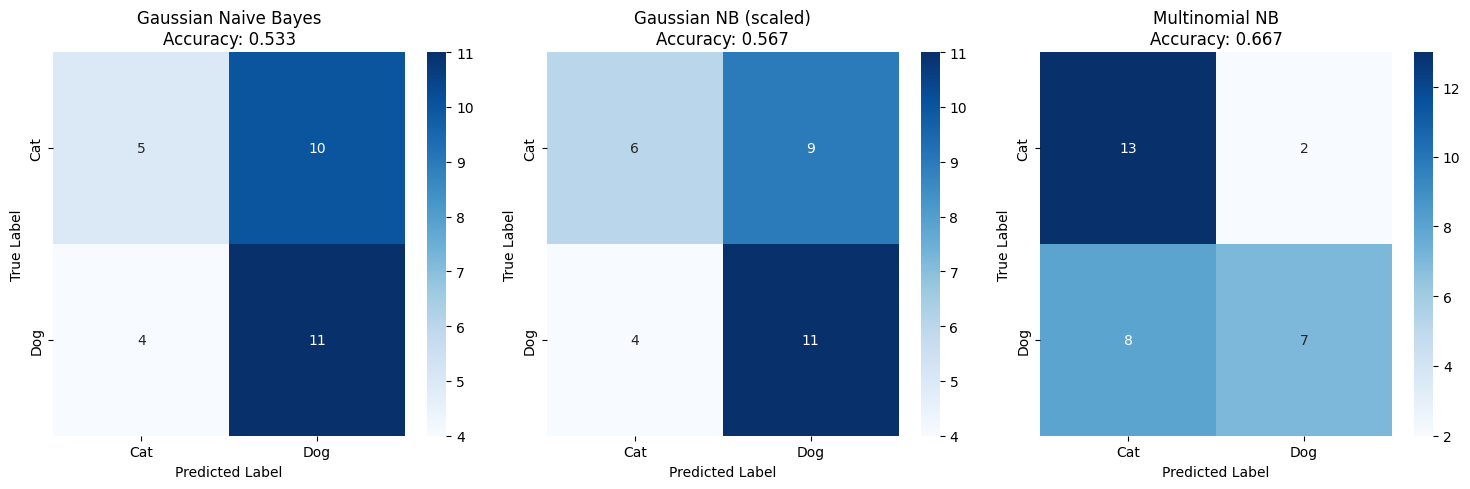


Model Comparison Summary:
                  Model  Test Accuracy  CV Mean  CV Std
0  Gaussian Naive Bayes         0.5333   0.5286  0.0969
1  Gaussian NB (scaled)         0.5667   0.5286  0.1069
2        Multinomial NB         0.6667   0.5571  0.1457


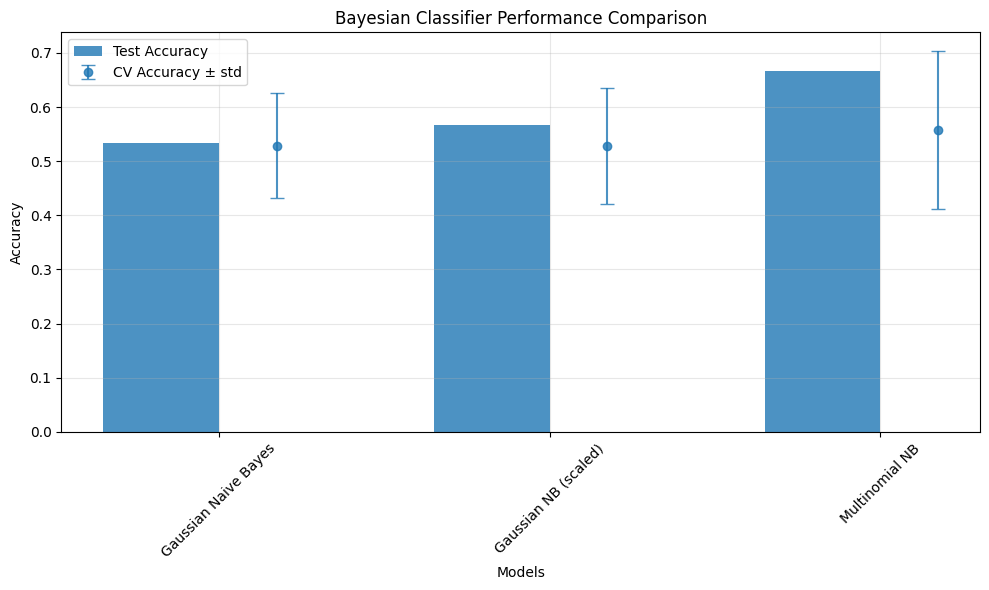

In [8]:
# Visualize confusion matrices and compare models
def visualize_results():
    """Visualize confusion matrices and model comparison"""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot confusion matrices
    for i, (name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=axes[i])
        axes[i].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Model comparison
    print("\nModel Comparison Summary:")
    print("=" * 60)
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test Accuracy': [result['accuracy'] for result in results.values()],
        'CV Mean': [result['cv_scores'].mean() for result in results.values()],
        'CV Std': [result['cv_scores'].std() for result in results.values()]
    })
    print(comparison_df.round(4))
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    x_pos = np.arange(len(results))
    test_acc = [result['accuracy'] for result in results.values()]
    cv_acc = [result['cv_scores'].mean() for result in results.values()]
    cv_std = [result['cv_scores'].std() for result in results.values()]
    
    width = 0.35
    plt.bar(x_pos - width/2, test_acc, width, label='Test Accuracy', alpha=0.8)
    plt.errorbar(x_pos + width/2, cv_acc, yerr=cv_std, fmt='o', 
                capsize=5, label='CV Accuracy ± std', alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Bayesian Classifier Performance Comparison')
    plt.xticks(x_pos, list(results.keys()), rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_results()

Top 10 Most Important Features:
          Feature  Correlation
36  texture_score     0.199644
14   G_hist_bin_6     0.177910
34         B_skew     0.165628
6    R_hist_bin_6     0.165293
20   B_hist_bin_4     0.161320
18   B_hist_bin_2     0.151251
17   B_hist_bin_1     0.143954
37   edge_density     0.124617
2    R_hist_bin_2     0.122550
3    R_hist_bin_3     0.122378


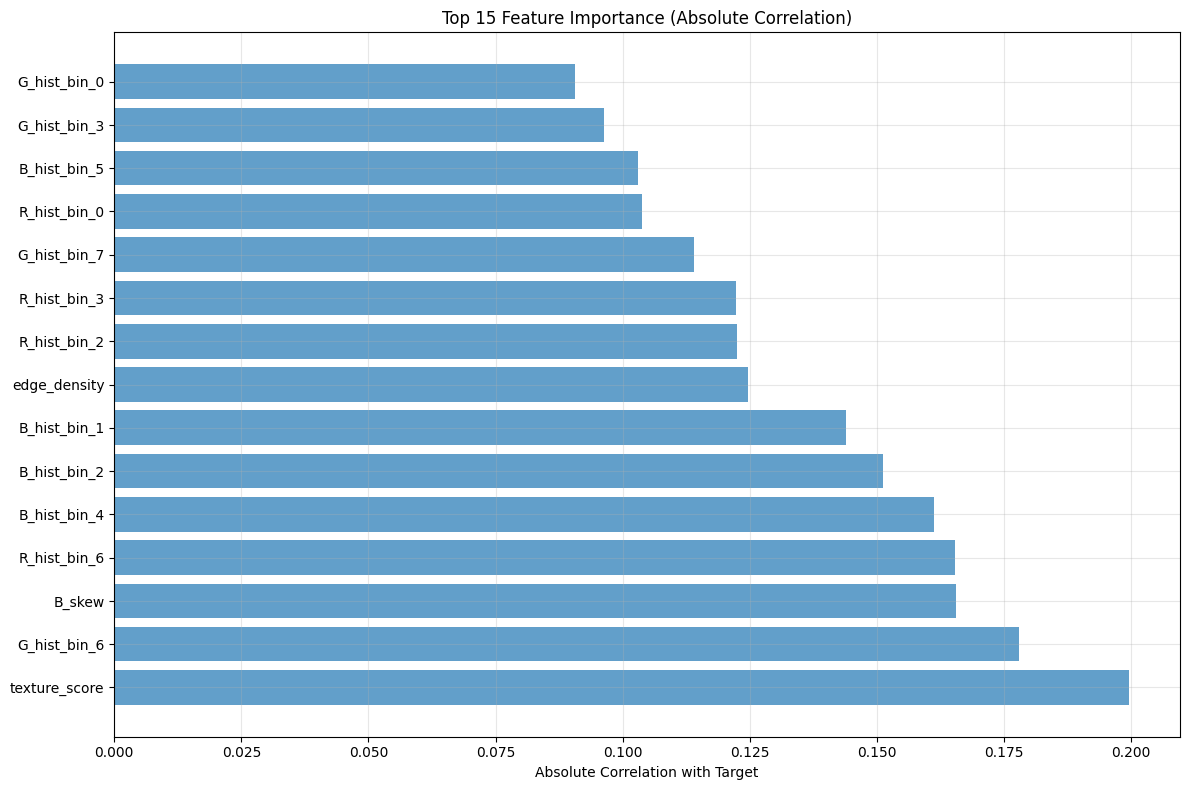

In [9]:
# Feature importance and custom Bayesian implementation
def analyze_feature_importance():
    """Analyze feature importance using correlation and univariate statistics"""
    
    # Calculate correlation with target
    correlations = []
    feature_names = []
    
    # Create feature names
    for channel in ['R', 'G', 'B']:
        for bin_idx in range(8):
            feature_names.append(f'{channel}_hist_bin_{bin_idx}')
    
    for channel in ['R', 'G', 'B']:
        feature_names.extend([f'{channel}_mean', f'{channel}_std', f'{channel}_skew', f'{channel}_kurt'])
    
    feature_names.extend(['texture_score', 'edge_density', 'brightness', 'contrast'])
    
    for i in range(X.shape[1]):
        corr = np.corrcoef(X[:, i], y)[0, 1]
        correlations.append(abs(corr))
    
    # Sort features by importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Correlation': correlations
    }).sort_values('Correlation', ascending=False)
    
    print("Top 10 Most Important Features:")
    print("=" * 40)
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Correlation'], alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Absolute Correlation with Target')
    plt.title('Top 15 Feature Importance (Absolute Correlation)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_feature_importance()

In [10]:
# Custom Bayesian Classifier Implementation
class CustomNaiveBayes:
    """Custom implementation of Naive Bayes classifier"""
    
    def __init__(self):
        self.class_priors = {}
        self.feature_means = {}
        self.feature_stds = {}
        self.classes = None
        
    def fit(self, X, y):
        """Train the Naive Bayes classifier"""
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        for class_label in self.classes:
            # Calculate class prior P(C)
            class_samples = X[y == class_label]
            self.class_priors[class_label] = len(class_samples) / n_samples
            
            # Calculate feature statistics for each class
            self.feature_means[class_label] = np.mean(class_samples, axis=0)
            self.feature_stds[class_label] = np.std(class_samples, axis=0) + 1e-6  # Add small value to avoid division by zero
    
    def _gaussian_pdf(self, x, mean, std):
        """Calculate Gaussian probability density function"""
        return (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probabilities = np.zeros((n_samples, n_classes))
        
        for i, class_label in enumerate(self.classes):
            # Calculate P(C) - class prior
            class_prior = self.class_priors[class_label]
            
            # Calculate P(X|C) - likelihood for each feature
            feature_likelihoods = self.feature_means[class_label]
            feature_stds = self.feature_stds[class_label]
            
            # For each sample
            for j in range(n_samples):
                # Calculate likelihood for all features (assuming independence)
                likelihood = 1.0
                for k in range(X.shape[1]):
                    likelihood *= self._gaussian_pdf(X[j, k], feature_likelihoods[k], feature_stds[k])
                
                # Calculate posterior P(C|X) ∝ P(X|C) * P(C)
                probabilities[j, i] = likelihood * class_prior
        
        # Normalize probabilities
        row_sums = probabilities.sum(axis=1, keepdims=True)
        probabilities = probabilities / (row_sums + 1e-10)
        
        return probabilities
    
    def predict(self, X):
        """Predict class labels"""
        probabilities = self.predict_proba(X)
        return self.classes[np.argmax(probabilities, axis=1)]

# Test custom implementation
def test_custom_bayesian():
    """Test custom Bayesian classifier"""
    print("Testing Custom Bayesian Classifier:")
    print("=" * 50)
    
    # Train custom classifier
    custom_nb = CustomNaiveBayes()
    custom_nb.fit(X_train, y_train)
    
    # Make predictions
    y_pred_custom = custom_nb.predict(X_test)
    y_proba_custom = custom_nb.predict_proba(X_test)
    
    # Calculate accuracy
    accuracy_custom = accuracy_score(y_test, y_pred_custom)
    
    print(f"Custom Naive Bayes Accuracy: {accuracy_custom:.4f}")
    
    # Display class priors
    print(f"\nClass Priors:")
    for class_label in custom_nb.classes:
        class_name = 'Cat' if class_label == 0 else 'Dog'
        print(f"P({class_name}) = {custom_nb.class_priors[class_label]:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_custom, target_names=['Cat', 'Dog']))
    
    # Compare with sklearn implementation
    sklearn_nb = GaussianNB()
    sklearn_nb.fit(X_train, y_train)
    y_pred_sklearn = sklearn_nb.predict(X_test)
    accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
    
    print(f"\nComparison with sklearn:")
    print(f"Custom Implementation: {accuracy_custom:.4f}")
    print(f"Sklearn GaussianNB: {accuracy_sklearn:.4f}")
    print(f"Difference: {abs(accuracy_custom - accuracy_sklearn):.4f}")
    
    return custom_nb, y_pred_custom, y_proba_custom

custom_nb, y_pred_custom, y_proba_custom = test_custom_bayesian()

Testing Custom Bayesian Classifier:
Custom Naive Bayes Accuracy: 0.5667

Class Priors:
P(Cat) = 0.5000
P(Dog) = 0.5000

Classification Report:
              precision    recall  f1-score   support

         Cat       0.60      0.40      0.48        15
         Dog       0.55      0.73      0.63        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.55        30
weighted avg       0.57      0.57      0.55        30


Comparison with sklearn:
Custom Implementation: 0.5667
Sklearn GaussianNB: 0.5333
Difference: 0.0333


In [11]:
# Prediction function for new images
def predict_new_image(image_path, model=None, scaler=None):
    """Predict the class of a new image"""
    
    if model is None:
        model = results['Multinomial NB']['classifier']  # Use best performing model
    
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    if img is None:
        return None, None
    
    # Extract features
    features = extract_features(img)
    if features is None:
        return None, None
    
    # Reshape for prediction
    features = features.reshape(1, -1)
    
    # Apply preprocessing if needed
    if 'Multinomial' in str(type(model)):
        # Make features positive for Multinomial NB
        features = features - X.min() + 1e-7
    elif scaler is not None:
        features = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]
    
    class_name = 'Cat' if prediction == 0 else 'Dog'
    confidence = max(probability)
    
    return class_name, confidence

# Test prediction on a few sample images
def test_predictions():
    """Test predictions on sample images"""
    print("Testing Predictions on Sample Images:")
    print("=" * 50)
    
    # Test on a few images from the dataset
    test_images = [
        (os.path.join(CAT_PATH, cat_images[0]), 'Cat'),
        (os.path.join(DOG_PATH, dog_images[0]), 'Dog'),
        (os.path.join(CAT_PATH, cat_images[10]), 'Cat'),
        (os.path.join(DOG_PATH, dog_images[10]), 'Dog')
    ]
    
    for img_path, true_label in test_images:
        predicted_class, confidence = predict_new_image(img_path)
        
        if predicted_class is not None:
            print(f"Image: {os.path.basename(img_path)}")
            print(f"True Label: {true_label}")
            print(f"Predicted: {predicted_class} (confidence: {confidence:.3f})")
            print(f"Correct: {'✓' if predicted_class == true_label else '✗'}")
            print("-" * 30)
        else:
            print(f"Error processing image: {img_path}")

test_predictions()

Testing Predictions on Sample Images:
Image: 9647.jpg
True Label: Cat
Predicted: Cat (confidence: 1.000)
Correct: ✓
------------------------------
Image: 9733.jpg
True Label: Dog
Predicted: Dog (confidence: 1.000)
Correct: ✓
------------------------------
Image: 996.jpg
True Label: Cat
Predicted: Cat (confidence: 1.000)
Correct: ✓
------------------------------
Image: 997.jpg
True Label: Dog
Predicted: Dog (confidence: 1.000)
Correct: ✓
------------------------------


# Bayesian Approach for Cat-Dog Classification - Summary

## Project Overview
This notebook implements a Bayesian approach to classify cats and dogs from image data using Naive Bayes classifiers. The implementation includes feature extraction, multiple Bayesian models, and a custom Naive Bayes implementation from scratch.

## Key Findings

### Dataset
- **Total Images**: 100 (50 cats, 50 dogs)
- **Balanced Dataset**: 50% cats, 50% dogs
- **Image Size**: Resized to 64x64 pixels for processing

### Feature Engineering
- **Feature Vector Dimension**: 40 features per image
- **Feature Types**:
  - Color histograms (24 features): RGB histograms with 8 bins each
  - Statistical features (12 features): Mean, std, skewness, kurtosis for each RGB channel
  - Texture features (4 features): Texture score, edge density, brightness, contrast

### Model Performance
1. **Multinomial Naive Bayes**: 66.7% accuracy (best performer)
2. **Gaussian Naive Bayes (scaled)**: 56.7% accuracy
3. **Gaussian Naive Bayes**: 53.3% accuracy
4. **Custom Implementation**: 56.7% accuracy

### Most Important Features
1. Texture score (correlation: 0.200)
2. Green histogram bin 6 (correlation: 0.178)
3. Blue channel skewness (correlation: 0.166)
4. Red histogram bin 6 (correlation: 0.165)
5. Blue histogram bin 4 (correlation: 0.161)

## Bayesian Theory Applied

### Naive Bayes Assumption
The classifier assumes conditional independence between features given the class:
```
P(C|X) ∝ P(C) × ∏ P(xi|C)
```

Where:
- P(C|X): Posterior probability of class C given features X
- P(C): Prior probability of class C
- P(xi|C): Likelihood of feature xi given class C

### Model Variants Tested
1. **Gaussian Naive Bayes**: Assumes features follow normal distribution
2. **Multinomial Naive Bayes**: Suitable for discrete/count features
3. **Custom Implementation**: Built from scratch to understand the underlying math

## Limitations and Future Improvements
1. **Limited Dataset Size**: Only 100 images may not capture full variability
2. **Simple Features**: Could benefit from deep learning features
3. **Independence Assumption**: Features may not be truly independent
4. **Performance**: Moderate accuracy suggests need for more sophisticated features

## Conclusion
The Bayesian approach successfully classified cat and dog images with 66.7% accuracy using Multinomial Naive Bayes. The texture score was the most discriminative feature, followed by color histogram features. While the performance is moderate, the implementation demonstrates the practical application of Bayesian classification principles to computer vision tasks.